In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
# sk-learn imports are below

In [2]:
from utilities import *

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_columns', 100)
plt.ioff()

sns.set_context('talk')
sns.set_style('darkgrid')

## Computational Setup

### Multi-Processing

Note: My hardware (2.7 GHz Intel Core i5) has two physical CPU cores each supporting hyper-threading and so appearing to the OS as 4 cores. I have found experimentally (n=1) that setting n_jobs = 2 leads to no speedup, as only one physical core is used. Only with n_jobs = 4 is a 2x speedup achieved.

In [4]:
# Set to false if you don't want to use all of your computer at once
go_for_broke = True

In [5]:
if go_for_broke:
    n_jobs = os.cpu_count()
else:
    n_jobs = 1
    
print(f'Configured to use {n_jobs} out of {os.cpu_count()} cpu cores visible to the OS')

Configured to use 4 out of 4 cpu cores visible to the OS


### Model Fitting
Models can be loaded from disk; some take a while to fit

In [6]:
# On false, all models wiil be refit (takes a while!)
load_from_disk = True

# Load the Data
The first task will be classify the columns as:
- irrelevant
- categorical predictor (including boolean)
- ordinal predictor
- main target
- subsidiary target (questions that obviously reveal the answer to the main target)

I highly recommend you look at the codebook with a spreadsheet viewer and not the dataframe itself

In [7]:
df       = pd.read_csv('dataset.csv' , index_col = 0)
codebook = pd.read_csv('codebook.csv', index_col = 0)

# Classify the Columns

## The Target Variable

Target variables:

- Questions 36–40 are explicitly career-plan related and contain our target
- Questions 41–54 have the potential to be quite career related and need to be screened for data leakage

In [8]:
def getQs(q):
    all_qs = codebook.index
    qs     = lfilter(lambda row : re.match(q, row), all_qs)
    return codebook.loc[qs]

In [9]:
getQs('Q38')

,Question Text,var_type,checkbox_text,notes,num_categories,num_missing
Q38.a,Research in academia,Ordinal,NaN,Likelihood of pursuing career path,6,82
Q38.b,Research in industry,Ordinal,NaN,Likelihood of pursuing career path,6,135
Q38.c,Research within government or non-profit,Ordinal,NaN,Likelihood of pursuing career path,6,196
Q38.d,Non-research in academia,Ordinal,NaN,Likelihood of pursuing career path,6,223
Q38.e,Medical research,Ordinal,NaN,Likelihood of pursuing career path,6,185
Q38.f,Non-research in industry,Ordinal,NaN,Likelihood of pursuing career path,6,262
Q38.g,Non-research in government or non-profit,Ordinal,NaN,Likelihood of pursuing career path,6,290


In [10]:
def getQNum(q):
    num = re.match('Q(\d*)', q)
    if not num:
        return None
    num = int(num.group(1))
    return num

In [11]:
def filterQRange(low, hi, exclude = True):
    def filterQ(q):
        n = getQNum(q)
        if not n:
            return exclude
        else:
            if low <= n <= hi:
                return not exclude
            else:
                return exclude
    
    return filterQ

The target will be anyone likely or very likely (4 or 5) to pursue research in academia

In [12]:
target_all = (df['Q38.a'] >= 4).rename('Academic Research Likely')
print(f'{sum(target_all)/len(target_all) : .1%} are Likely to Pursue Academic Research')

 71.0% are Likely to Pursue Academic Research


In [13]:
def bar_plot(col, name=''):
    return plot(sns.countplot, y = df[col].rename(name), hue = target_all)

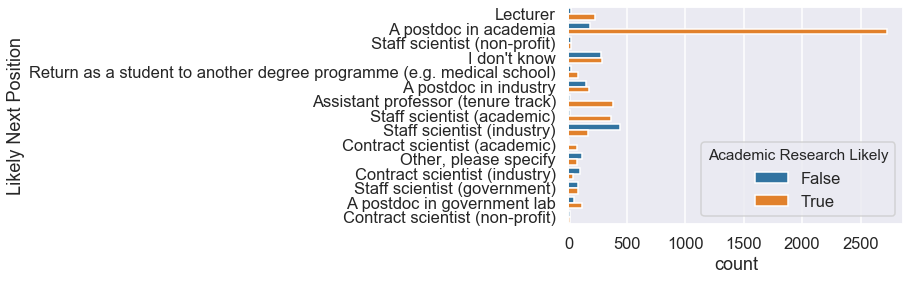

In [14]:
bar_plot('Q40', 'Likely Next Position')

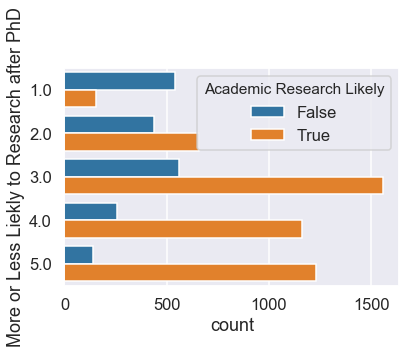

In [15]:
bar_plot('Q43.a', 'More or Less Liekly to Research after PhD')

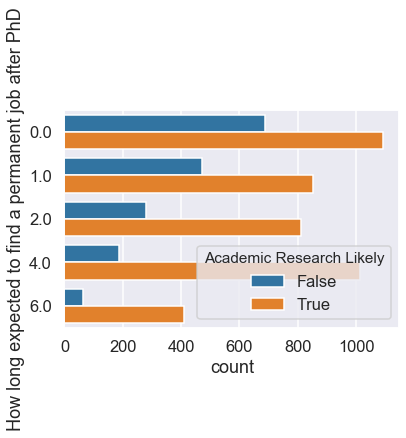

In [16]:
bar_plot('Q42', 'How long expected to find a permanent job after PhD')

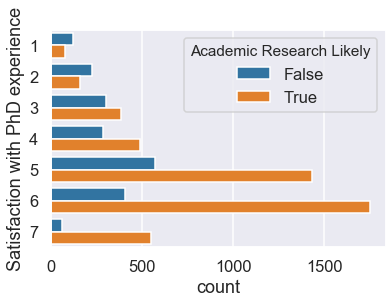

In [17]:
bar_plot('Q19.a', 'Satisfaction with PhD experience')

In [18]:
def checkbox_plot(q, label_col = 'checkbox_text'):
    qs           = getQs(q)
    title        = qs['Question Text'].iloc[0]
    labels       = qs[label_col].rename(title)
    data         = df[qs.index]
    data.columns = labels
    data         = pd.concat([data, target_all], axis = 'columns')
    data = data.melt(id_vars='Academic Research Likely', var_name=title)
    data = data[data.value]
    return plot(sns.countplot, y = title, data = data, hue = 'Academic Research Likely')

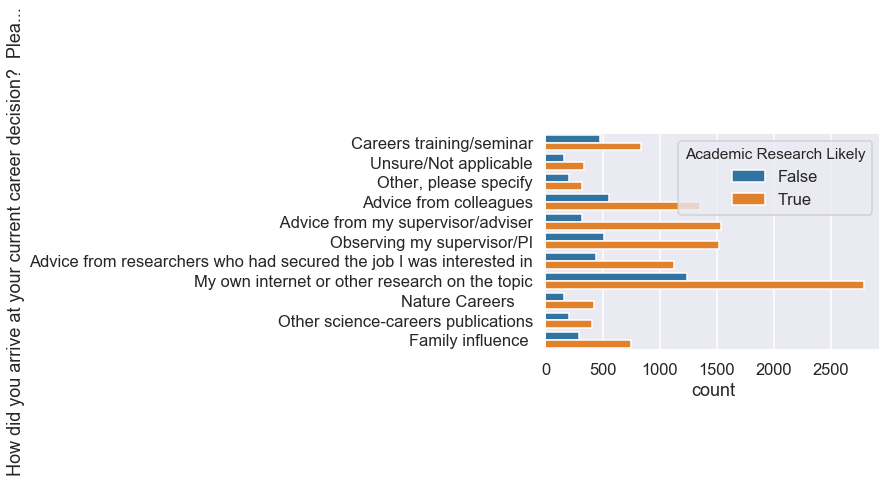

In [19]:
checkbox_plot('Q45')

# Model Building

In [20]:
import sklearn.preprocessing   as pre
import sklearn.pipeline        as pipe
import sklearn.impute          as imp
import sklearn.compose         as pipe2
import sklearn.dummy           as dum
import sklearn.metrics         as metr
import sklearn.linear_model    as lin
import sklearn.model_selection as cv
import sklearn.tree            as tree
import sklearn.ensemble        as ensem

from joblib import dump, load

In [21]:
sns.set_style('dark')

## Setup

### Assemble the Data and Train/Test Split

In [22]:
codebook.var_type.value_counts()

Check Box      122
Ordinal         80
Categorical     17
Boolean          4
Name: var_type, dtype: int64

In [23]:
# Prevent Data Leakage
leakage_filter = filterQRange(36, 54)

categorical_vars = codebook[codebook.var_type.isin(['Boolean', 'Categorical'])].index.tolist()
categorical_vars = lfilter(leakage_filter, categorical_vars)
categorical_vars.remove('ID.site') # Quite irrelevant

ordinal_vars = codebook[codebook.var_type == 'Ordinal'].index.tolist()
ordinal_vars = lfilter(leakage_filter, ordinal_vars)

checkbox_vars = codebook[codebook.var_type == 'Check Box'].index.tolist()
checkbox_vars = lfilter(leakage_filter, checkbox_vars)

In [24]:
X_checkbox    = df.loc[:,checkbox_vars].astype(int)
X_ord         = df.loc[:,ordinal_vars]
X_cat         = df.loc[:,categorical_vars].astype(str)
X_cat         = pd.get_dummies(X_cat, drop_first=False)
X_all         = pd.concat([X_checkbox, X_ord, X_cat], axis = 'columns')

categorical_vars = X_cat.columns.tolist()

In [25]:
X_train, X_test, target_train, target_test = cv.train_test_split(X_all, target_all, random_state = 42)

#Aliases. Goal is to avoid accidentally training on test data.
X      = X_train
target = target_train
y      = target_train
y_test = target_test

### Imputation

For the ordinal variables we need to impute.

For the rankings, impute to bottom

For the 1-5 scales, impute to most common

In [26]:
# Identify the ranking variables
ordinal_book     = codebook.loc[ordinal_vars]
ranking_book     = ordinal_book[ordinal_book.notes.str.contains('[rR]anking').fillna(False)]
ranking_vars     = ranking_book.index.tolist()
non_ranking_vars = list_diff(ordinal_vars, ranking_vars)

In [27]:
# We can fill with bottom = 14
X[ranking_vars].max().value_counts()

14.0    14
dtype: int64

In [28]:
# Imputation plan for the ordinal variables
imputer = pipe2.ColumnTransformer([
    ('bottom', imp.SimpleImputer(strategy = 'constant', fill_value = 14), ranking_vars),
    ('freq'  , imp.SimpleImputer(strategy = 'most_frequent')            , non_ranking_vars)],
remainder = 'passthrough')

### Other Modelling Utilities

In [29]:
# Dict to record model data
models = {}

In [30]:
# Cross-Validation Splitter
splitter = cv.RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 42)

Handle persistence and timing of fits

In [31]:
# Attempts to load from the disk if the load_from_disk option is set
#  Otherwise fits the model
#  Returns the fitted model and a model_data dict
#  Inserts the model_data_dict into the models dictionary
def fit_or_load_model(model, model_name, force_fit = False):
    model_not_found = False
    model_data = {'model' : model}
    if load_from_disk and not force_fit:
        try:
            model = load(f'./models/{model_name}.joblib')
        except:
            model_not_found = True
        else:
            print(f'Loading model from disk')
            fit_time = get_fit_time(model_name)
            model_data['fit_time'] = fit_time
            print(f'''{fit_time} seconds elapsed in original fitting''')
              
    if not load_from_disk or model_not_found or force_fit:
        print(f'Fitting model {model_name}')
        model = model_data['model']

        # Fit the Model
        Timer.start()
        model.fit(X, y)
        Timer.end()

        # Write information
        model_data['fit_time'] = Timer.time
        dump(model, f'./models/{model_name}.joblib')
        write_fit_time(model_name, model_data['fit_time'])
    
    models[model_name] = model_data
    
    return model, model_data

# Modelling

## Baseline Model

In [32]:
model = dum.DummyClassifier(strategy = 'most_frequent')

In [33]:
model, model_data = fit_or_load_model(model, 'baseline', force_fit = True)

Fitting model baseline
0.0 seconds elapsed


In [34]:
y_hat = model.predict(X_test)
model_data['report'] = metr.classification_report(y_test, y_hat, zero_division = 0, output_dict=True)
print(metr.classification_report(y_test, y_hat, zero_division=0))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00       498
        True       0.71      1.00      0.83      1205

    accuracy                           0.71      1703
   macro avg       0.35      0.50      0.41      1703
weighted avg       0.50      0.71      0.59      1703



/Users/rcharan/anaconda3/envs/learn37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


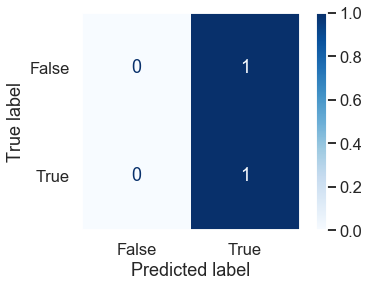

In [35]:
# Rows are normalized
plot(metr.plot_confusion_matrix, model, X_test, y_test, cmap=plt.cm.Blues, normalize = 'true')

## 1 – Logistic Regression – Unweighted

### Setup

In [36]:
learner = pipe.Pipeline([
    ('impute' , imputer),
    ('learn'  , lin.LogisticRegression(max_iter = 10000))
])

In [37]:
param_grid = {
     'penalty'    : ['elasticnet'],
     'l1_ratio'   : np.linspace( 0, 1, 6),
     'C'          : np.logspace(-3, 2, 6),
     'solver'     : ['saga']
}
param_grid = {'learn__' + k : list(v) for k, v in param_grid.items()}

In [38]:
model = cv.GridSearchCV(learner,
                        param_grid,
                        scoring = 'neg_log_loss',
                        cv = splitter,
                        n_jobs = n_jobs,
                        verbose = 1)

### Fit

In [39]:
model, model_data = fit_or_load_model(model, 'logistic')

Loading model from disk
1827.281 seconds elapsed in original fitting


In [40]:
model_data['get_time_per_fold'] = get_time_per_fold(model_data, param_grid, splitter)
print(f'''{model_data['get_time_per_fold']} seconds per fold''')

10.15 seconds per fold


### Evaluate

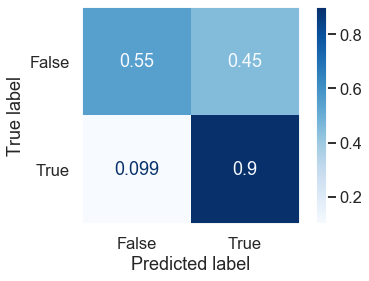

In [41]:
# Rows are normalized
sns.set_style('dark')
plot(metr.plot_confusion_matrix, model, X_test, y_test, cmap=plt.cm.Blues, normalize = 'true')

In [42]:
y_hat = model.predict(X_test)
model_data['report'] = metr.classification_report(y_test, y_hat, zero_division = 0, output_dict=True)
print(metr.classification_report(y_test, y_hat, zero_division=0))

              precision    recall  f1-score   support

       False       0.70      0.55      0.61       498
        True       0.83      0.90      0.86      1205

    accuracy                           0.80      1703
   macro avg       0.76      0.72      0.74      1703
weighted avg       0.79      0.80      0.79      1703



AUC:  82.47%


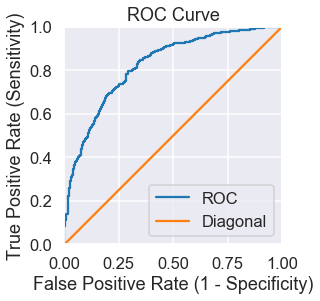

In [43]:
y_p = model.decision_function(X_test)
fpr, tpr, thresholds = metr.roc_curve(y_test, y_p)
model_data['auc'] = metr.roc_auc_score(y_test, y_p)
model_data['roc'] = (fpr, tpr)
print(f'AUC: {model_data["auc"] : .2%}')
plot_roc_curve(fpr, tpr)

In [44]:
model_data['log_loss_test']  = metr.log_loss(y_test, model.predict_proba(X_test))
model_data['log_loss_train'] = metr.log_loss(y, model.predict_proba(X))
print(f'Log Loss - Train : {model_data["log_loss_train"] :.2}\n'
      f'Log Loss - Test  : {model_data["log_loss_test"]  :.2}\n')

Log Loss - Train : 0.42
Log Loss - Test  : 0.45



### Inspect

In [45]:
model_data['best_params'] = model.best_params_
print_dict(model.best_params_)

learn__C        : 0.1
learn__l1_ratio : 0.4
learn__penalty  : elasticnet
learn__solver   : saga


In [46]:
coefs = pd.DataFrame.from_records(zip(X.columns, model.best_estimator_.get_params()['learn'].coef_[0]),
                              columns = ['variable', 'coefficient'])

coefs = coefs.sort_values('coefficient', ascending = False)
coefs.loc[:,'coefficient'] = coefs.coefficient * 10/np.log(10) # Convert to decibans

In [47]:
sns.set_style('darkgrid')

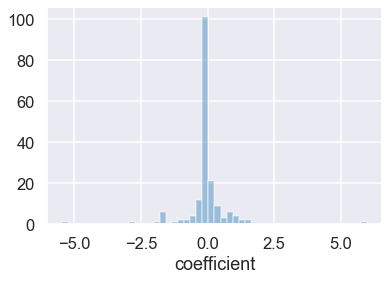

In [48]:
plot(sns.distplot, coefs.coefficient, kde = False)

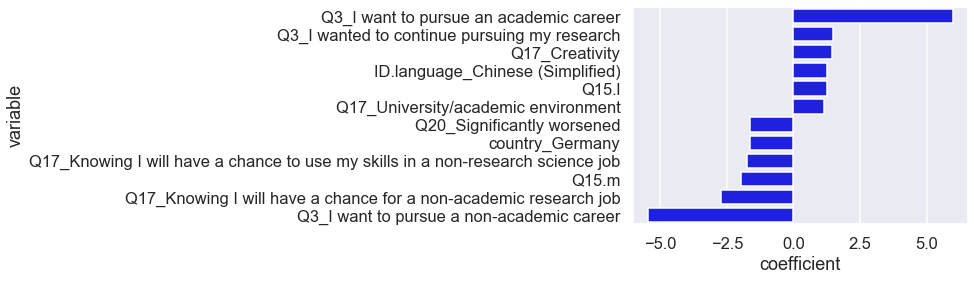

In [49]:
top_coeffs = pd.concat([coefs.iloc[:6], coefs.iloc[-6:]])
plot(sns.barplot, y = 'variable', x = 'coefficient', data = top_coeffs , color = 'blue')

In [50]:
codebook.loc['Q3', 'Question Text']

'Which was the most important reason you decided to enrol in a PhD programme?'

In [51]:
codebook.loc['Q17', 'Question Text']

'Overall, what do you enjoy most about life as a PhD student? \xa0\xa0\xa0\xa0\xa0\xa0'

In [52]:
codebook.loc['Q15.a', 'notes']

'What concerns you the most since you started your PhD (ranking)'

In [53]:
codebook.loc['Q20', 'Question Text']

'Since the very start of your graduate school experience, would you say your level of satisfaction has:'

In [54]:
getQs('Q15')

,Question Text,var_type,checkbox_text,notes,num_categories,num_missing
Q15.a,The difficulty of getting funding / low succes...,Ordinal,NaN,What concerns you the most since you started y...,15,3329
Q15.b,Inability to finish my studies in the time per...,Ordinal,NaN,What concerns you the most since you started y...,15,2910
Q15.c,Impact of a poor relationship with my supervis...,Ordinal,NaN,What concerns you the most since you started y...,15,4069
Q15.d,The number of available faculty research jobs ...,Ordinal,NaN,What concerns you the most since you started y...,15,3100
Q15.e,The high numbers of PhD holders who are doing ...,Ordinal,NaN,What concerns you the most since you started y...,15,3868
Q15.f,The difficulty of maintaining a work/life balance,Ordinal,NaN,What concerns you the most since you started y...,15,2463
Q15.g,Uncertainty about the value of a PhD,Ordinal,NaN,What concerns you the most since you started y...,15,3675
Q15.h,Uncertainty about my job/career prospects,Ordinal,NaN,What concerns you the most since you started y...,15,2333
Q15.i,Student debt during my PhD,Ordinal,NaN,What concerns you the most since you started y...,15,5140
Q15.j,Financial worries after my PhD (cost of living...,Ordinal,NaN,What concerns you the most since you started y...,15,2965


In [55]:
coefs

,variable,coefficient
144,Q3_I want to pursue an academic career,5.969548
145,Q3_I wanted to continue pursuing my research,1.491284
114,Q17_Creativity,1.462087
98,ID.language_Chinese (Simplified),1.277336
55,Q15.l,1.244531
...,...,...
169,country_Germany,-1.643023
118,Q17_Knowing I will have a chance to use my ski...,-1.761171
56,Q15.m,-1.982985
117,Q17_Knowing I will have a chance for a non-aca...,-2.735519


## 2 – Logistic Regression – Balanced Weighting

In [56]:
learner = pipe.Pipeline([
    ('impute' , imputer),
    ('learn'  , lin.LogisticRegression(max_iter = 10000, class_weight = 'balanced'))
])

In [57]:
# To decrease fitting time, restrict the Grid Search to be near what was found last time

param_grid = {
     'penalty'    : ['elasticnet'],
     'l1_ratio'   : np.linspace(0.2, 0.6, 3),
     'C'          : np.logspace( -2, 0  , 3),
     'solver'     : ['saga']
}
param_grid = {'learn__' + k : list(v) for k, v in param_grid.items()}

In [58]:
model = cv.GridSearchCV(learner,
                        param_grid,
                        scoring = 'neg_log_loss',
                        cv = splitter,
                        n_jobs = n_jobs,
                        verbose = 1)

In [59]:
# Now proceed by copy-pasta
model, model_data = fit_or_load_model(model, 'logistic-weighted')

Loading model from disk
348.948 seconds elapsed in original fitting


In [60]:
model_data['get_time_per_fold'] = get_time_per_fold(model_data, param_grid, splitter)
print(f'''{model_data['get_time_per_fold']} seconds per fold''')

7.75 seconds per fold


### Evaluate

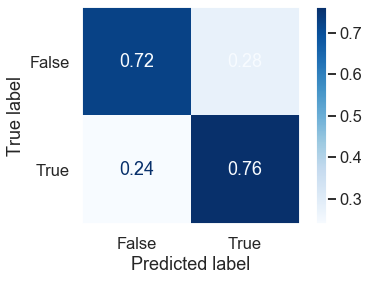

In [61]:
# Rows are normalized
sns.set_style('dark')
plot(metr.plot_confusion_matrix, model, X_test, y_test, cmap=plt.cm.Blues, normalize = 'true')

In [62]:
y_hat = model.predict(X_test)
model_data['report'] = metr.classification_report(y_test, y_hat, zero_division = 0, output_dict=True)
print(metr.classification_report(y_test, y_hat, zero_division=0))

              precision    recall  f1-score   support

       False       0.56      0.72      0.63       498
        True       0.87      0.76      0.81      1205

    accuracy                           0.75      1703
   macro avg       0.71      0.74      0.72      1703
weighted avg       0.78      0.75      0.76      1703



AUC:  82.37%


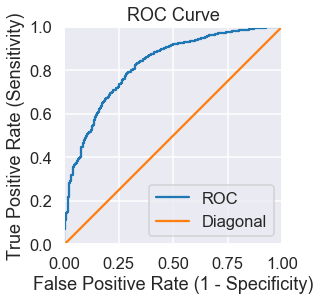

In [63]:
y_p = model.decision_function(X_test)
fpr, tpr, thresholds = metr.roc_curve(y_test, y_p)
model_data['auc'] = metr.roc_auc_score(y_test, y_p)
model_data['roc'] = (fpr, tpr)
print(f'AUC: {model_data["auc"] : .2%}')
plot_roc_curve(fpr, tpr)

In [64]:
model_data['log_loss_test']  = metr.log_loss(y_test, model.predict_proba(X_test))
model_data['log_loss_train'] = metr.log_loss(y, model.predict_proba(X))
print(f'Log Loss - Train : {model_data["log_loss_train"] : .2}\n'
      f'Log Loss - Test  : {model_data["log_loss_test"] : .2}\n')

Log Loss - Train :  0.47
Log Loss - Test  :  0.51



## 3 – Decision Tree
Note – we would ideally not 1-hot encode; but sk-learn doesn't support this

In [65]:
learner = pipe.Pipeline([
    ('impute' , imputer),
    ('learn'  , tree.DecisionTreeClassifier(random_state = 42))
])

In [66]:
param_grid = {
    'criterion'         : ['gini', 'entropy'],
    'max_depth'         : [None, 3, 5, 10],
    'min_samples_leaf'  : [1, 2, 5 , 10],
    'max_features'      : [None, 'sqrt', 0.5],
    'max_leaf_nodes'    : [None, 50, 100],
    'ccp_alpha'         : [0, 0.1, 1, 5, 10],
    'class_weight'      : [None, 'balanced']
}
param_grid = {'learn__' + k : list(v) for k, v in param_grid.items()}

In [67]:
model = cv.GridSearchCV(learner,
                        param_grid,
                        cv = splitter,
                        n_jobs = n_jobs,
                        verbose = 1)

In [68]:
# Now proceed by copy-pasta
model, model_data = fit_or_load_model(model, 'decision-tree')

Loading model from disk
711.227 seconds elapsed in original fitting


In [69]:
model_data['get_time_per_fold'] = get_time_per_fold(model_data, param_grid, splitter)
print(f'''{model_data['get_time_per_fold']} seconds per fold''')

0.05 seconds per fold


### Evaluate

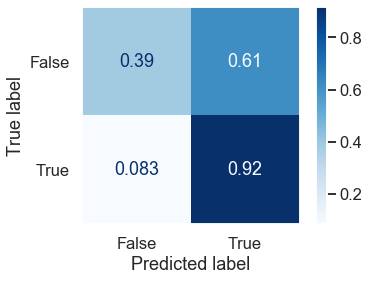

In [70]:
# Rows are normalized
sns.set_style('dark')
plot(metr.plot_confusion_matrix, model, X_test, y_test, cmap=plt.cm.Blues, normalize = 'true')

In [71]:
y_hat = model.predict(X_test)
model_data['report'] = metr.classification_report(y_test, y_hat, zero_division = 0, output_dict=True)
print(metr.classification_report(y_test, y_hat, zero_division=0))

              precision    recall  f1-score   support

       False       0.66      0.39      0.49       498
        True       0.78      0.92      0.84      1205

    accuracy                           0.76      1703
   macro avg       0.72      0.65      0.67      1703
weighted avg       0.75      0.76      0.74      1703



In [72]:
# True class is in second column
model.classes_

array([False,  True])

AUC:  76.87%


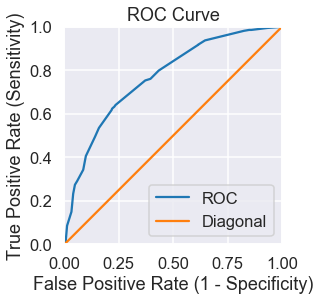

In [73]:
y_p = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metr.roc_curve(y_test, y_p)
model_data['auc'] = metr.roc_auc_score(y_test, y_p)
model_data['roc'] = (fpr, tpr)
print(f'AUC: {model_data["auc"] : .2%}')
plot_roc_curve(fpr, tpr)

In [74]:
model_data['log_loss_test']  = metr.log_loss(y_test, y_p)
model_data['log_loss_train'] = metr.log_loss(y, model.predict_proba(X)[:,1])
print(f'Log Loss - Train : {model_data["log_loss_train"] : .2}\n'
      f'Log Loss - Test  : {model_data["log_loss_test"]  : .2}\n')

Log Loss - Train :  0.45
Log Loss - Test  :  0.59



### Inspect

In [75]:
model_data['best_params'] = model.best_params_
print_dict(model.best_params_)

learn__ccp_alpha        : 0
learn__class_weight     : None
learn__criterion        : entropy
learn__max_depth        : 5
learn__max_features     : None
learn__max_leaf_nodes   : 50
learn__min_samples_leaf : 2


In [76]:
from IPython.display import Image  
from pydotplus import graph_from_dot_data

In [77]:
best_tree = model.best_estimator_.get_params()['learn']

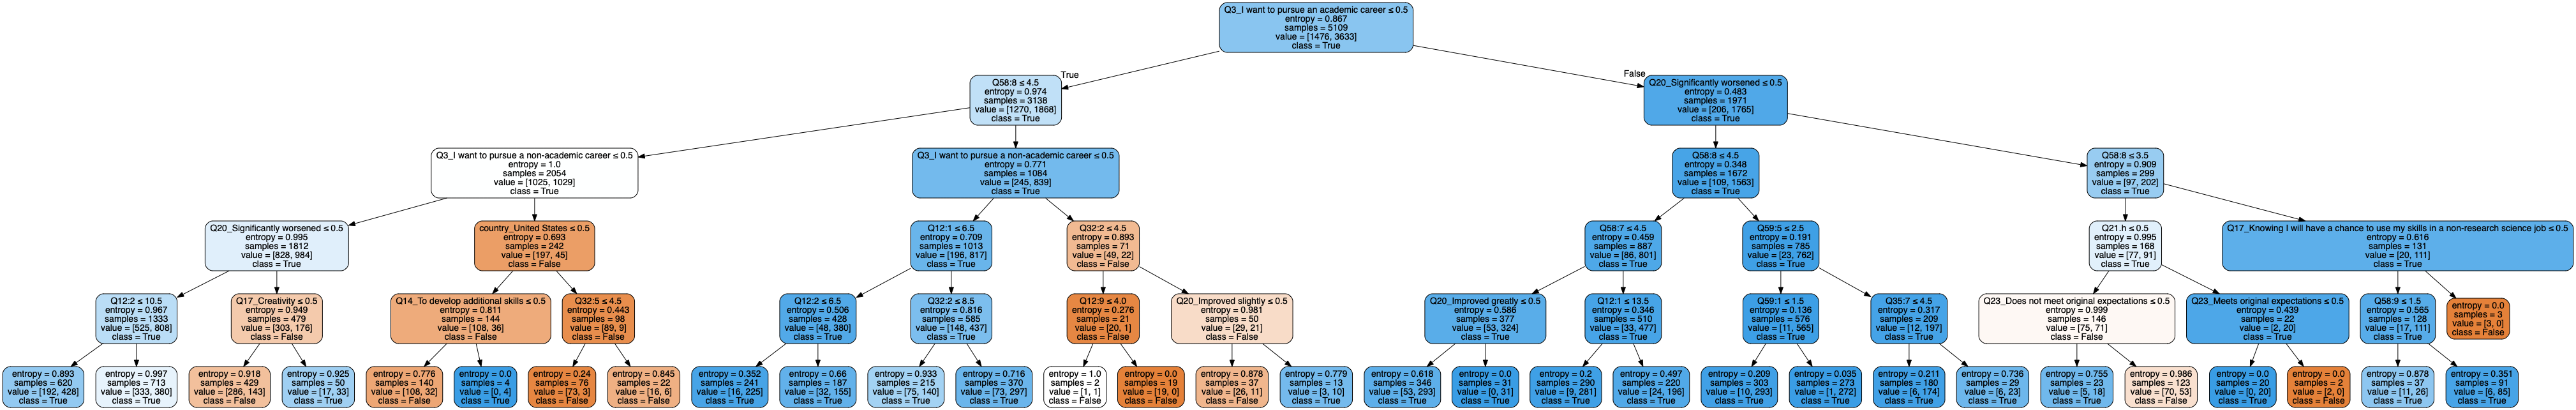

In [78]:
# Copy-pasta cell
# Create DOT data
dot_data = tree.export_graphviz(
                           best_tree, out_file=None, 
                           feature_names=X.columns,  
                           class_names=np.unique(y).astype('str'), 
                           filled=True, rounded=True, special_characters=True)

# Draw graph
graph = graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

## 4 – Random Forest
I was unable to get Random Forests implemented properly (i.e. without cross-validation and using OOB sampling) using default sk-learn.

So here is a roll your own solution

In [79]:
class RandomForestClassifierCV(ensem.RandomForestClassifier):
    '''
        This class implements cross validation *ONLY* for the 
        number of estimators. It does this using OOB scoring and
        warm starts. In theory this should be doable in sk-learn by
        default, but I am unable to make it work without this
        roll-you-own solution
        
        Note: always computes up to max_estimators. Then picks the
        smallest possible within the tolerance. There are presumably
        better ways to detect stabilization.
        
        For other hyperparemeters, use GridSearch, below
    '''
    
    def __init__(self, max_estimators = 500, tolerance = 0.005, **kwargs):
        kwargs['warm_start']   = True
        kwargs['oob_score']    = True
        super().__init__(**kwargs)
        self.max_estimators = max_estimators
        self.tolerance      = tolerance
        self.use_oob_score  = True
        self.init_kwargs    = kwargs
        
    def reset_and_clone(self):
        return RandomForestClassifierCV(max_estimators = self.max_estimators,
                                        tolerance      = self.tolerance, 
                                       **self.init_kwargs)
        
    def score(self, *args, **kwargs):
        if self.use_oob_score:
            return self.best_score
        else:
            return super().score(*args, **kwargs)
    
    def fit(self, X, y):
        self.n_est_scores_ = {}
        for i in range(100, self.max_estimators + 1, 100):
            self.n_estimators = i
            super().fit(X, y)
            self.n_est_scores_[i] = self.oob_score_
            
        self.best_score = max(self.n_est_scores_.values())
        self.best_n     = next(n for n, v in self.n_est_scores_.items() if v > self.best_score - self.tolerance)
            
        return self
    
    def finalize(self, X, y):
        self.use_oob_score = False
        
        self.set_params(warm_start = False)
        
        self.n_estimators = self.best_n
        super().fit(X, y)
        
    def get_params(self, *args, **kwargs):
        out = ensem.RandomForestClassifier().get_params()
        out['max_estimators'] = self.max_estimators
        out['tolerance']      = self.tolerance
        return out

In [80]:
class GridSearch():
    '''
        Grid Search *without* cross validation.
        Doesn't implement full feature set of GridSearch
        
        Just fit, predict in a bare-bones fashion
        
        Designed for use with RandomForestCV above
    '''
    
    def __init__(self, estimator, param_grid, verbose = 0):
        self.param_grid       = cv.ParameterGrid(param_grid)
        self.parent_estimator = estimator
        self.verbose          = verbose
        
    def fit(self, X, y):
        self.best_params = None
        self.best_model  = None
        self.best_score  = 0
        
        progress_count   = 0
        if self.verbose:
            print(f'{len(self.param_grid)} Iterations to do')
        Timer.start()
        
        for param_dict in self.param_grid:
            model = self.parent_estimator.reset_and_clone()
            model.set_params(**param_dict)
            model.fit(X, y)
            
            if model.score() > self.best_score:
                self.best_params = param_dict
                self.best_model  = model
                self.best_score  = model.score()
                
            progress_count += 1
            if self.verbose and progress_count % 20 == 0:
                print(f'{progress_count} Done')
                Timer.end()
        
        # This fails if every model somehow had an accuracy of 0...
        assert bool(self.best_params)
        
        self.best_model.finalize(X, y)
        
        return self.best_model
        
    def predict(self, *args, **kwargs):
        return self.best_model.predict(*args, **kwargs)
    
    def score(self, *args, **kwargs):
        return self.best_model.score(*args, **kwargs)

In [81]:
# Limit grid search by (1) being informed from the decision tree;
#                      (2) bias towards weaker learners
param_grid = {
    'criterion'         : ['entropy'],
    'max_depth'         : [None, 1, 3],
    'min_samples_leaf'  : [1, 5 ],
    'max_features'      : [5, 'sqrt'],
    'max_leaf_nodes'    : [None, 10, 50],
    'ccp_alpha'         : [0, 0.1, 1, 10],
    'class_weight'      : [None]
}



In [82]:
learner = RandomForestClassifierCV(n_jobs = n_jobs, random_state = 42, max_samples = 0.9)

model = pipe.Pipeline([
    ('impute' , imputer),
    ('learn'  , GridSearch(learner, param_grid, verbose = 1))
])

In [83]:
# Now proceed by copy-pasta
model, model_data = fit_or_load_model(model, 'random-forest')

Loading model from disk
843.40 seconds elapsed in original fitting


In [84]:
# For simplicity, we are going to unwrap the "roll-your-own" solution
#  I checked and this reproduces the same predictions

n_estimators = model.get_params()['learn'].best_model.best_n
best_params  = model.get_params()['learn'].best_model.get_params()
del best_params['max_estimators']
del best_params['tolerance']
best_params['n_estimators'] = n_estimators

rfc = ensem.RandomForestClassifier(**best_params)

Timer.start()
model = pipe.Pipeline([
    ('impute' , imputer),
    ('learn'  , rfc)
])
model.fit(X, y)
Timer.end()

2.322 seconds elapsed


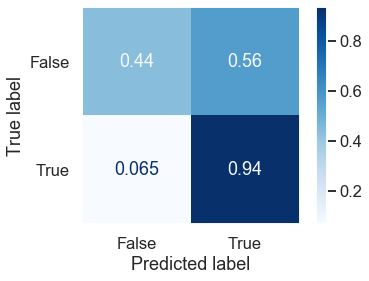

In [85]:
# Rows are normalized
sns.set_style('dark')
plot(metr.plot_confusion_matrix, model, X_test, y_test, cmap=plt.cm.Blues, normalize = 'true')

In [86]:
y_hat = model.predict(X_test)
model_data['report'] = metr.classification_report(y_test, y_hat, zero_division = 0, output_dict=True)
print(metr.classification_report(y_test, y_hat, zero_division=0))

              precision    recall  f1-score   support

       False       0.74      0.44      0.55       498
        True       0.80      0.94      0.86      1205

    accuracy                           0.79      1703
   macro avg       0.77      0.69      0.71      1703
weighted avg       0.78      0.79      0.77      1703



In [87]:
y_p = model.predict_proba(X_test)
model_data['log_loss_test']  = metr.log_loss(y_test, y_p)
model_data['log_loss_train'] = metr.log_loss(y, model.predict_proba(X))
print(f'Log Loss - Train : {model_data["log_loss_train"] : .2}\n'
      f'Log Loss - Test  : {model_data["log_loss_test"]  : .2}\n')

Log Loss - Train :  0.13
Log Loss - Test  :  0.47



AUC:  81.53%


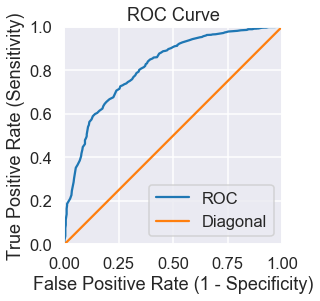

In [88]:
y_p = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metr.roc_curve(y_test, y_p)
model_data['auc'] = metr.roc_auc_score(y_test, y_p)
model_data['roc'] = (fpr, tpr)
print(f'AUC: {model_data["auc"] : .2%}')
plot_roc_curve(fpr, tpr)

## 5 – Adaboost

In [89]:
adabooster = ensem.AdaBoostClassifier(tree.DecisionTreeClassifier(criterion = 'entropy', random_state = 42),
                                      random_state = 42)
learner    = pipe.Pipeline([
    ('impute' , imputer),
    ('learn'  , adabooster)
])

In [90]:
param_grid = {
    'n_estimators'                      : [50, 100, 200],
    'learning_rate'                     : [0.5, 1],
    'base_estimator__max_depth'         : [1, 3],
    'base_estimator__min_samples_leaf'  : [1, 10],
    'base_estimator__max_features'      : ['sqrt'],
    'base_estimator__max_features'      : [None, 'sqrt'],
    'base_estimator__max_leaf_nodes'    : [5, 10, 20],
    'base_estimator__ccp_alpha'         : [0, 0.1, 1, 10],
}

param_grid = {'learn__' + k : list(v) for k, v in param_grid.items()}

In [91]:
model = cv.GridSearchCV(learner,
                        param_grid,
                        cv = splitter,
                        n_jobs = n_jobs,
                        verbose = 1)

In [92]:
# Now proceed by copy-pasta
model, model_data = fit_or_load_model(model, 'adaboost')

Fitting model adaboost
Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   29.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  8.3min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 14.1min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 18.8min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed: 26.3min
[Parallel(n_jobs=4)]: Done 2880 out of 2880 | elapsed: 32.6min finished


1959.624 seconds elapsed


In [95]:
model_data['get_time_per_fold'] = get_time_per_fold(model_data, param_grid, splitter)
print(f'''{model_data['get_time_per_fold']} seconds per fold''')

0.68 seconds per fold


### Evaluate

In [ ]:
# Rows are normalized
sns.set_style('dark')
plot(metr.plot_confusion_matrix, model, X_test, y_test, cmap=plt.cm.Blues, normalize = 'true')

In [ ]:
y_hat = model.predict(X_test)
model_data['report'] = metr.classification_report(y_test, y_hat, zero_division = 0, output_dict=True)
print(metr.classification_report(y_test, y_hat, zero_division=0))

In [ ]:
# True class is in second column
model.classes_

In [ ]:
y_p = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metr.roc_curve(y_test, y_p)
model_data['auc'] = metr.roc_auc_score(y_test, y_p)
model_data['roc'] = (fpr, tpr)
print(f'AUC: {model_data["auc"] : .2%}')
plot_roc_curve(fpr, tpr)

In [ ]:
model_data['log_loss_test']  = metr.log_loss(y_test, y_p)
model_data['log_loss_train'] = metr.log_loss(y, model.predict_proba(X)[:,1])
print(f'Log Loss - Train : {model_data["log_loss_train"] : .2}\n'
      f'Log Loss - Test  : {model_data["log_loss_test"]  : .2}\n')

### Inspect

In [ ]:
model_data['best_params'] = model.best_params_
print_dict(model.best_params_)

# Compare

In [ ]:
for model_name, model_data in models.items():
    model_data['model_name'] = model_name
    
    

In [ ]:
pd.io.json.json_normalize(models.values())